### Exponential Mechanism for Differential Privacy

In this notebook we extend the basic building blocks to include an exponential mechanism for releasing medians.

We'll first build an algorithm for releasing DP medians by postprocessing a DP histogram:

In [ ]:
from mock_dp_library import *


def postprocess_quantile(categories, counts, q: float):
    """Postprocess a histogram release into a quantile estimate.

    :param categories: ordered data of length t
    :param counts: estimates of the counts of `categories`, of length t
    :param q: proportion of entries to the left, ranging from [0, 1]
    :return the category corresponding to the q-quantile of counts"""
    # approximate the cdf via `counts`
    cdf = np.cumsum(counts)
    cdf /= cdf[-1]

    return categories[np.argmax(cdf >= q)]


def release_dp_median_via_histogram(x, candidates, epsilon):
    # release a DP estimate of the histogram 
    dp_counts = release_dp_histogram(x, epsilon=epsilon, categories=candidates)

    # postprocess
    return postprocess_quantile(candidates, dp_counts, q=0.5)

We can also release DP medians via the exponential mechanism:

In [ ]:
def exponential_mechanism(x, candidates, epsilon, scorer, sensitivity):
    # score each candidate (can be more computationally efficient to score all at once)
    scores = np.array([scorer(x, candidate) for candidate in candidates])

    # for numerical stability; omitting this line results in the same probabilities
    scores -= scores.max()

    # compute likelihood of selecting each candidate
    likelihoods = np.exp(epsilon * scores / (2 * sensitivity))

    # normalize to a probability
    probabilities = likelihoods / likelihoods.sum()

    # select one candidate wrt the selection probabilities
    return np.random.choice(a=candidates, p=probabilities)


def score_median(x, candidate):
    """Scores a candidate based on proximity to the median."""
    return min(sum(x <= candidate), sum(x >= candidate))


def release_dp_median(x, candidates, epsilon):
    return exponential_mechanism(x, candidates, epsilon,
        scorer=score_median, 
        sensitivity=1)


Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale. This time we are being more formal with how we handle the data. Type inference itself might release the existence of `bb` in the data, so we handle this case explicitly.

Excerpt from [2005 PUMS Data Dictionary](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict05.pdf#page=28).

```
SCHL 2  
Educational attainment  

	bb .N/A (less than 3 years old)  
	01 .No school completed  
	02 .Nursery school to grade 4  
	03 .Grade 5 or grade 6  
	04 .Grade 7 or grade 8  
	05 .Grade 9  
	06 .Grade 10  
	07 .Grade 11  
	08 .Grade 12 no diploma  
	09 .High school graduate  
	10 .Some college, but less than 1 year  
	11 .One or more years of college, no degree  
	12 .Associate's degree  
	13 .Bachelor's degree  
	14 .Master's degree  
	15 .Professional school degree  
	16 .Doctorate degree
```

In [ ]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv",
    # map 'bb' to 0 when parsing 'educ'
    converters={'educ': lambda v: 0 if v == 'bb' else int(v)})

# define public information
educ_levels = list(range(17))  # inferred from codebook excerpt

educ = data['educ'].values

In [ ]:
release_dp_median_via_histogram(
    educ, candidates=educ_levels, epsilon=1.)

11

In [ ]:
release_dp_median(
    educ, candidates=educ_levels, epsilon=1.)

11

#### Show repeated releases on one sample of data

In [ ]:
x = bootstrap(educ, 100)
n_sims = 100
epsilon = 1.0

history_hist = []
history_expo = []
for i in range(n_sims):
	history_hist.append(release_dp_median_via_histogram(
		x=x, candidates=educ_levels, epsilon=epsilon))
	history_expo.append(release_dp_median(
		x=x, candidates=educ_levels, epsilon=epsilon))

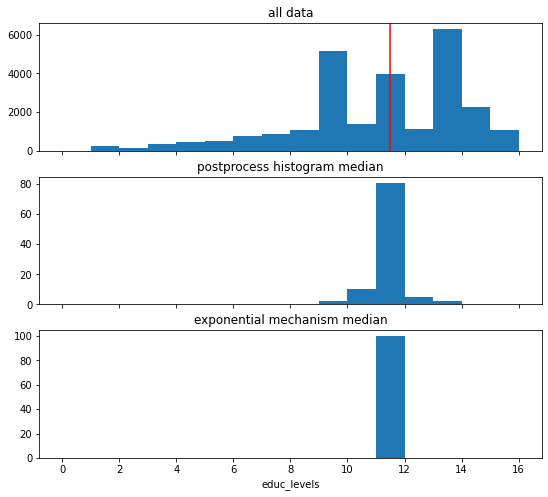

In [ ]:
import matplotlib.pyplot as plt

fig, (ax_data, ax_hist, ax_expo) = plt.subplots(nrows=3, figsize=(9, 8), sharex=True)

ax_data.set_title("all data")
ax_data.hist(educ, bins=educ_levels)
# also show true sample median, centered in the bin
ax_data.axvline(x=np.median(x) + 0.5, color="r")

ax_hist.set_title("postprocess histogram median")
ax_hist.hist(history_hist, bins=educ_levels)

ax_expo.set_title("exponential mechanism median")
ax_expo.hist(history_expo, bins=educ_levels)
ax_expo.set_xlabel("educ_levels")

plt.show()

#### Simulate both mechanisms across bootstrapped datasets to compare performance

In [ ]:
n_sims = 100

n_seq = np.logspace(start=np.log10(50), stop=np.log10(1000), num=10).astype(int)
print("N sequence      ", n_seq)

ep_seq = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.01), num=5), decimals=2)
print("epsilon sequence", ep_seq)


agg_history = []

for i, bootdata_size in enumerate(n_seq):
    print(f"{i+1} of {len(n_seq)}: {bootdata_size}")

    for j, epsilon in enumerate(ep_seq):
        sq_error_expo = score_expo = 0
        sq_error_hist = score_hist = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, bootdata_size)
            sensitive_median = np.median(bootdata)

            # Evaluate histogram postprocessing
            dp_median_hist = release_dp_median_via_histogram(
                x=bootdata, candidates=educ_levels, epsilon=epsilon)
            sq_error_hist += (dp_median_hist - sensitive_median) ** 2
            score_hist += score_median(bootdata, dp_median_hist) / bootdata_size

            # Evaluate exponential mechanism
            dp_median_expo = release_dp_median(
                x=bootdata, candidates=educ_levels, epsilon=epsilon)
            sq_error_expo += (dp_median_expo - sensitive_median) ** 2
            scorge_expo += score_median(bootdata, dp_median_expo) / bootdata_size


        agg_history.append([
            bootdata_size,
            epsilon,
            np.sqrt(sq_error_hist / n_sims),
            np.sqrt(sq_error_expo / n_sims),
            np.mean(score_hist / n_sims),
            np.mean(score_expo / n_sims),
        ])
        
utility_columns = ["RMSE (histogram)", "RMSE (exponential)", "Score / N (histogram)", "Score / N (exponential)"]
agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", *utility_columns])
print(agg_history)

N sequence       [  49   69   97  135  189  264  368  513  716 1000]
epsilon sequence [1.   0.32 0.1  0.03 0.01]
1 of 10: 49
2 of 10: 69
3 of 10: 97
4 of 10: 135
5 of 10: 189
6 of 10: 264
7 of 10: 368
8 of 10: 513
9 of 10: 716
10 of 10: 1000
       N  epsilon  RMSE (histogram)  RMSE (exponential)  \
0     49     1.00          1.187434            0.663325   
1     49     0.32          4.941660            2.395830   
2     49     0.10          7.140028            4.663690   
3     49     0.03          7.356630            5.748913   
4     49     0.01          7.135825            5.125427   
5     69     1.00          0.959166            0.400000   
6     69     0.32          3.519943            1.161895   
7     69     0.10          5.963221            4.317407   
8     69     0.03          7.054077            5.596427   
9     69     0.01          7.103520            5.373081   
10    97     1.00          0.640312            0.282843   
11    97     0.32          2.426932            0.9

Graphing our results is often a case of finding an approximate template and then tweaking it to convey the exact details of interest to your reader. This template for showing the utility of DP releases will likely be commonly useful across your homeworks and project.

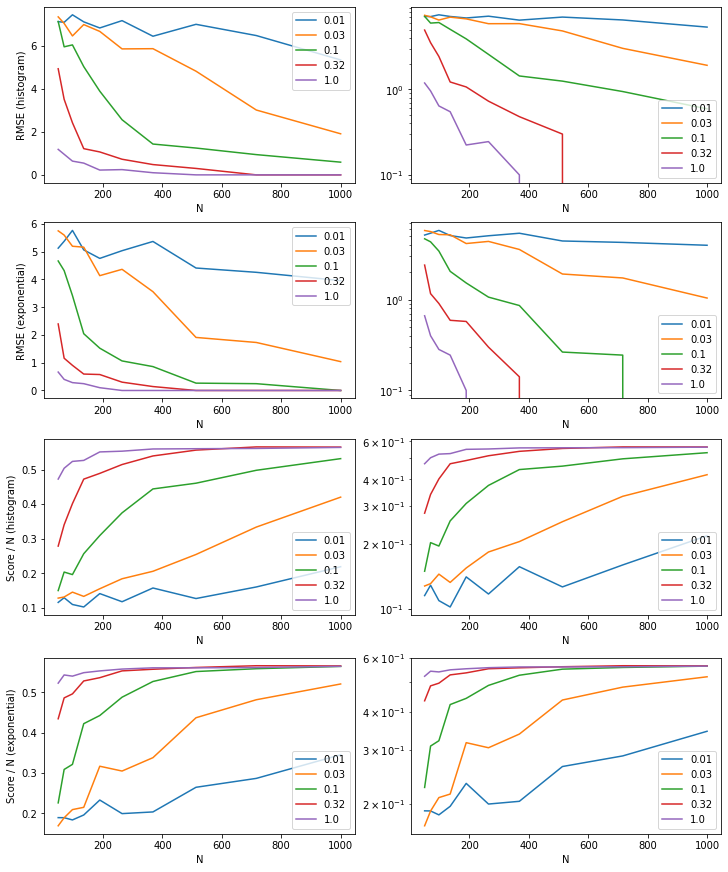

In [ ]:
def plot_row(axs, column):
    axs[0].set_ylabel(column)
    axs[1].set_yscale("log")
    for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
        for ax in axs:
            subhistory.plot(x="N", y=column, label=epsilon_sim, ax=ax)

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 12), layout='constrained')
for axs_row, column in zip(axs, utility_columns):
    plot_row(axs_row, column)